# Library

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader

In [21]:
# check GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


# Hyperparameters

In [22]:
classes = ['Cat', 'Dog']

In [23]:
batch_size = 128
epochs = 5
lr = 0.0001
SAVE_MODEL_PATH = "/kaggle/working/resnet50_best.pth"

# Load Dataset

In [27]:
train_transform = transforms.Compose([
                 transforms.Resize((224,224)),
                 transforms.RandomVerticalFlip(p=0.3),
                 transforms.RandomHorizontalFlip(p=0.5),
                 transforms.RandomRotation(45),
                 transforms.RandomGrayscale(p=0.3),
                 transforms.ToTensor(),
                 transforms.RandomErasing()
                 ]
                 )
test_transform = transforms.Compose([
                 transforms.Resize((224,224)),
                 transforms.ToTensor(),
                 ]
                 )

In [28]:
train_data = torchvision.datasets.ImageFolder(root='/kaggle/input/cvdl-q5/dataset/training_dataset',transform=train_transform)
test_data = torchvision.datasets.ImageFolder(root='/kaggle/input/cvdl-q5/dataset/validation_dataset',transform=test_transform)

print(f'train_data 數量 : {len(train_data)}')
print(f'test_data 數量 : {len(test_data)}')

train_loader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(dataset=test_data,batch_size=batch_size,shuffle=True,num_workers=2)

train_data 數量 : 16200
test_data 數量 : 1800


In [29]:
print(train_data.classes)
print(test_data.classes)

['Cat', 'Dog']
['Cat', 'Dog']


# Define model

In [30]:
from torchvision import models

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
def Optimizer(model,learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#     optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.9)
    return criterion,optimizer

# Show image in traing

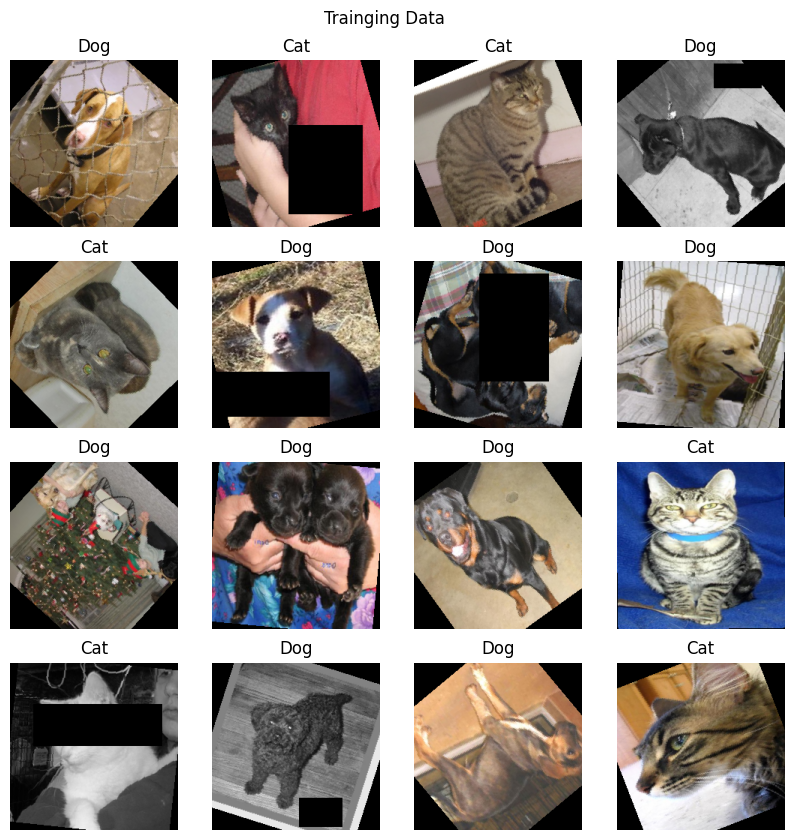

In [32]:
data_iterator = iter(train_loader)

inputs, labels = next(data_iterator)

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img = inputs[i]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    label = labels[i].item()
    title = classes[label]
    plt.title(title)
    
    plt.axis('off')
plt.suptitle(f'Trainging Data', y=0.93)

plt.show()

# define train

In [33]:
def train (model,epochs,learing_rate):
    
    trainLoss = []
    valLoss = []
    trainAcc = []
    valAcc = []
    criterion,optimizer = Optimizer(model,learing_rate)
    # Best Model acc
    best_acc = 0.0

    # Train epochs rounds
    for epoch in range(epochs): 

        # train_epoch_loss
        train_epoch_loss = 0.0 

        # train class correct & class total of each mini_patch
        train_class_correct = list(0. for i in range(len(classes)))
        train_class_total = list(0. for i in range(len(classes)))

        # Run all train dataset
        for i, data in enumerate(train_loader, 0):
        
            # One batch data
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear optimizer graident
            optimizer.zero_grad()
            # Model output of each batch from train_dataset
            outputs = model(inputs)

            # Compute Loss & Update loss
            batch_loss = criterion(outputs, labels)
            batch_loss.backward()
            optimizer.step()
            
            # 1. Compute train_batch_loss
            train_epoch_loss += batch_loss.item() 

            # 2. Compute train_class_correct of each batch
            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                train_class_correct[label] += batch_correct[j].item()
                train_class_total[label] += 1
            
        # Compute Loss & Acc & F1Score of training
        train_epoch_loss = train_epoch_loss / len(train_loader)
        train_epoch_accurncy = sum(train_class_correct) / sum(train_class_total) * 100
        print('[Epoch:%2d]' % (epoch + 1))
        print('Train Accuracy of All : %.3f %%' % (train_epoch_accurncy))
        print('Train Loss of All : %.3f ' % (train_epoch_loss))
        print("----------------------------------------")
        trainLoss.append(train_epoch_loss)
        trainAcc.append(train_epoch_accurncy)
        # Reset metrics of training
        train_epoch_loss = 0.0 
        train_class_correct = list(0. for i in range(len(classes)))
        train_class_total = list(0. for i in range(len(classes)))

        # Validation class correct & class total
        val_class_correct = list(0. for i in range(len(classes)))
        val_class_total = list(0. for i in range(len(classes)))
        val_loss = 0.0

        # Validation every epoch
        validation = test_loader
        with torch.no_grad():
            # Run all Validation dataset
            for data in validation:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                # Model output of each batch from Validation_dataset
                outputs = model(images)

                # 1. Compute val_batch_loss
                batch_loss = criterion(outputs, labels)
                val_loss += batch_loss.item()
                
                # 2. Compute val_class_correct of each batch
                _, predicted = torch.max(outputs, 1)
                batch_correct = (predicted == labels).squeeze()
                for j in range(len(labels)):
                    label = labels[j]
                    val_class_correct[label] += batch_correct[j].item()
                    val_class_total[label] += 1
        # print each class accurancy of  Validation
        for i in range(len(classes)):
            label = classes[i]
            print('Accuracy of %5s : %2d %%' % (label, 100 * val_class_correct[i] / val_class_total[i]))
        # Compute Loss & Acc & F1Score of Validation 
        val_accurncy = sum(val_class_correct) / sum(val_class_total) * 100
        val_loss = val_loss / len(validation)

        print('Validation Accuracy of All : %.3f %%' % (val_accurncy))
        print('Validation Loss of All : %.3f ' % (val_loss))
        print("----------------------------------------")
        valLoss.append(val_loss)
        valAcc.append(val_accurncy)

        # Save best model
        if val_accurncy > best_acc:
            best_acc = val_accurncy
            torch.save(model.state_dict(), SAVE_MODEL_PATH)
    print('Finished Training')
    return trainAcc,valAcc,trainLoss,valLoss


In [34]:
trainAcc,valAcc,trainLoss,valLoss = train(model,epochs,lr)

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Epoch: 1]
Train Accuracy of All : 94.228 %
Train Loss of All : 0.143 
----------------------------------------
Accuracy of   Cat : 98 %
Accuracy of   Dog : 99 %
Validation Accuracy of All : 99.000 %
Validation Loss of All : 0.034 
----------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Epoch: 2]
Train Accuracy of All : 96.420 %
Train Loss of All : 0.089 
----------------------------------------
Accuracy of   Cat : 98 %
Accuracy of   Dog : 99 %
Validation Accuracy of All : 99.111 %
Validation Loss of All : 0.040 
----------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Epoch: 3]
Train Accuracy of All : 97.173 %
Train Loss of All : 0.072 
----------------------------------------
Accuracy of   Cat : 98 %
Accuracy of   Dog : 99 %
Validation Accuracy of All : 99.056 %
Validation Loss of All : 0.025 
----------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Epoch: 4]
Train Accuracy of All : 97.377 %
Train Loss of All : 0.064 
----------------------------------------
Accuracy of   Cat : 98 %
Accuracy of   Dog : 99 %
Validation Accuracy of All : 98.944 %
Validation Loss of All : 0.024 
----------------------------------------


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[Epoch: 5]
Train Accuracy of All : 97.617 %
Train Loss of All : 0.063 
----------------------------------------
Accuracy of   Cat : 98 %
Accuracy of   Dog : 99 %
Validation Accuracy of All : 98.944 %
Validation Loss of All : 0.111 
----------------------------------------
Finished Training


# Show Result

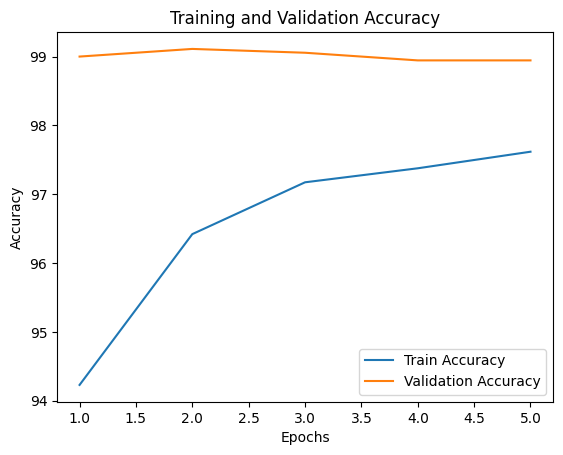

In [35]:
epochs = list(range(1, 6))

plt.plot(epochs, trainAcc, label='Train Accuracy', linestyle='-')

plt.plot(epochs, valAcc, label='Validation Accuracy', linestyle='-')

plt.legend()

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('accuracy_plot.png')
plt.show()


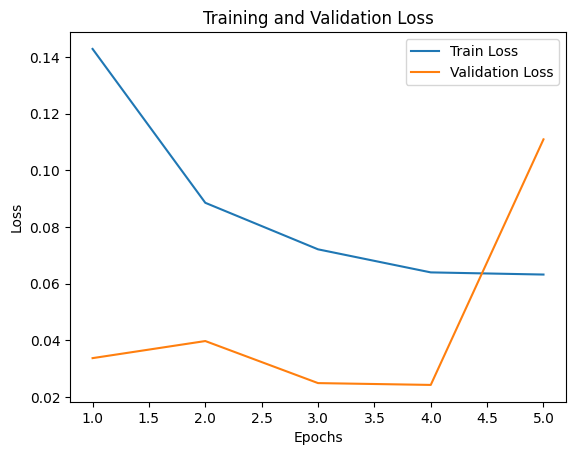

In [36]:
epochs = list(range(1, 6))

plt.plot(epochs, trainLoss, label='Train Loss', linestyle='-')

plt.plot(epochs, valLoss, label='Validation Loss', linestyle='-')

plt.legend()

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss_plot.png')
plt.show()

In [37]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('resnet50_best.pth')

/kaggle/working


/kaggle/working/resnet50_best.pth